here we are importing model for age and gender detection

In [2]:
!gdown https://drive.google.com/uc?id=1_aDScOvBeBLCn_iv0oxSO8X1ySQpSbIS

Downloading...
From (original): https://drive.google.com/uc?id=1_aDScOvBeBLCn_iv0oxSO8X1ySQpSbIS
From (redirected): https://drive.google.com/uc?id=1_aDScOvBeBLCn_iv0oxSO8X1ySQpSbIS&confirm=t&uuid=ecd92061-4324-42fe-b07b-7c53df759b13
To: /content/modelNweight.zip
100% 86.2M/86.2M [00:01<00:00, 73.5MB/s]


In [3]:
!unzip modelNweight.zip

Archive:  modelNweight.zip
   creating: modelNweight/
  inflating: modelNweight/age_deploy.prototxt  
  inflating: modelNweight/age_net.caffemodel  
  inflating: modelNweight/gender_deploy.prototxt  
  inflating: modelNweight/gender_net.caffemodel  
  inflating: modelNweight/opencv_face_detector.pbtxt  
  inflating: modelNweight/opencv_face_detector_uint8.pb  


In [4]:
import cv2 as cv
from google.colab.patches import cv2_imshow
import math
import time

In [8]:
# Load model files
faceProto = "modelNweight/opencv_face_detector.pbtxt"
faceModel = "modelNweight/opencv_face_detector_uint8.pb"
genderProto = "modelNweight/gender_deploy.prototxt"
genderModel = "modelNweight/gender_net.caffemodel"

# Load the neural networks
faceNet = cv.dnn.readNet(faceModel, faceProto)
genderNet = cv.dnn.readNet(genderModel, genderProto)

# List for gender classification
genderList = ['Male', 'Female']
MODEL_MEAN_VALUES = (78.4263377603, 87.7689143744, 114.895847746)

# Function to detect faces in an image
def getFaceBox(net, frame, conf_threshold=0.7):
    frameOpencvDnn = frame.copy()
    frameHeight, frameWidth = frame.shape[:2]

    # Convert image to blob format for the model
    blob = cv.dnn.blobFromImage(frameOpencvDnn, 1.0, (300, 300), [104, 117, 123], True, False)
    net.setInput(blob)
    detections = net.forward()

    bboxes = []
    for i in range(detections.shape[2]):
        confidence = detections[0, 0, i, 2]
        if confidence > conf_threshold:
            x1 = int(detections[0, 0, i, 3] * frameWidth)
            y1 = int(detections[0, 0, i, 4] * frameHeight)
            x2 = int(detections[0, 0, i, 5] * frameWidth)
            y2 = int(detections[0, 0, i, 6] * frameHeight)
            bboxes.append([x1, y1, x2, y2])
            cv.rectangle(frameOpencvDnn, (x1, y1), (x2, y2), (0, 255, 0), int(round(frameHeight / 150)), 8)

    return frameOpencvDnn, bboxes

# Function for gender detection
def gender_detector(frame):
    frameFace, bboxes = getFaceBox(faceNet, frame)

    for bbox in bboxes:
        face = frame[max(0, bbox[1]-20):min(bbox[3]+20, frame.shape[0]-1),
                     max(0, bbox[0]-20):min(bbox[2]+20, frame.shape[1]-1)]

        blob = cv.dnn.blobFromImage(face, 1.0, (227, 227), MODEL_MEAN_VALUES, swapRB=False)
        genderNet.setInput(blob)
        genderPreds = genderNet.forward()
        gender = genderList[genderPreds[0].argmax()]

        label = "{}".format(gender)
        cv.putText(frameFace, label, (bbox[0], bbox[1]-10), cv.FONT_HERSHEY_SIMPLEX, 0.8, (0, 255, 255), 2, cv.LINE_AA)

    return frameFace

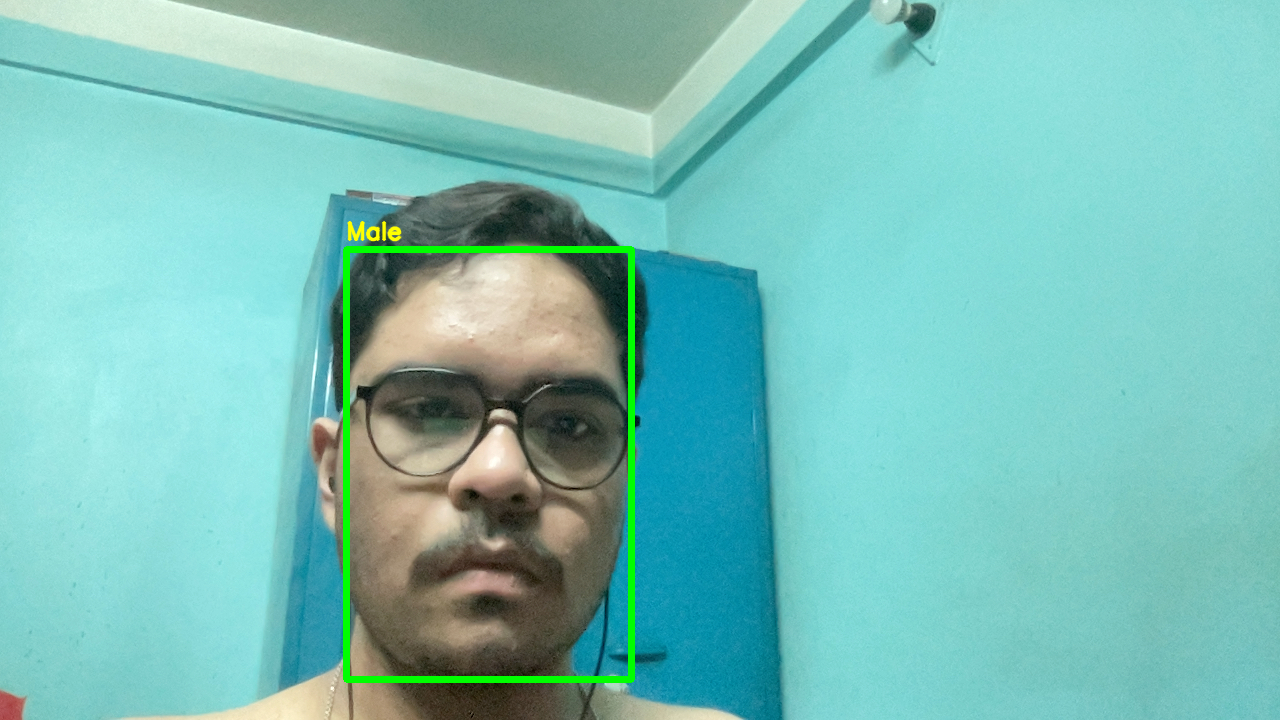

In [9]:
input_img = cv.imread("Photo-1.jpeg")
if input_img is None:
    print("Error: Image not found or could not be loaded.")
else:
    output_img = gender_detector(input_img)
    cv2_imshow(output_img)